In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset = pd.read_csv('./diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Tukey Method

# Import required libraries
from collections import Counter

# Outlier detection 
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# List of Outliers
Outliers_to_drop = detect_outliers(dataset.drop('Outcome', axis=1),0,list(dataset.drop('Outcome', axis=1)))
dataset.drop('Outcome', axis=1).loc[Outliers_to_drop]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
88,15,136,70,32,110,37.1,0.153,43
159,17,163,72,41,114,40.9,0.817,47
298,14,100,78,25,184,36.6,0.412,46
455,14,175,62,30,0,33.6,0.212,38
75,1,0,48,20,0,24.7,0.140,22
...,...,...,...,...,...,...,...,...
459,9,134,74,33,60,25.9,0.460,81
489,8,194,80,0,0,26.1,0.551,67
537,0,57,60,0,0,21.7,0.735,67
666,4,145,82,18,0,32.5,0.235,70


In [4]:
#Create New Dataset without Outliers
good_data=dataset.drop(dataset.index[Outliers_to_drop]).reset_index(drop = True)
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               639 non-null    int64  
 1   Glucose                   639 non-null    int64  
 2   BloodPressure             639 non-null    int64  
 3   SkinThickness             639 non-null    int64  
 4   Insulin                   639 non-null    int64  
 5   BMI                       639 non-null    float64
 6   DiabetesPedigreeFunction  639 non-null    float64
 7   Age                       639 non-null    int64  
 8   Outcome                   639 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 45.1 KB


Class Split
0    439
1    200
Name: Outcome, dtype: int64


Text(0, 0.5, 'Count')

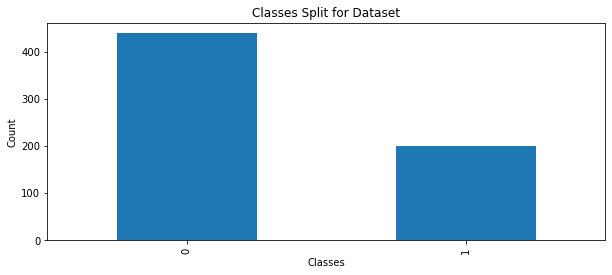

In [5]:
#Class Balance
print('Class Split')
print(good_data['Outcome'].value_counts())
good_data['Outcome'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [6]:
#Prepare for Models for Comparison

#Create x and y variables
x = good_data.drop('Outcome', axis=1).to_numpy()
Y = good_data['Outcome'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Model
from sklearn.linear_model import LogisticRegression

In [7]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear',class_weight='balanced',
                                               random_state=100))])
pipeline.insert(0,pipe_logreg)

# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(0,param_gridlogreg)

In [8]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logistic Regression Learning Curve


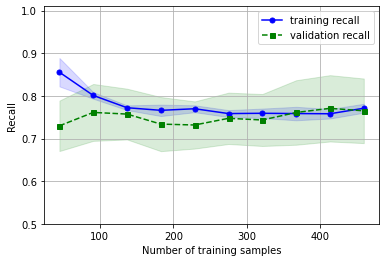

In [9]:
#Plot Learning Curve
print('Logistic Regression Learning Curve')
plot_learning_curves(pipe_logreg)

Model Evaluation - Recall Score
Logistic Regression 0.76 +/- 0.05




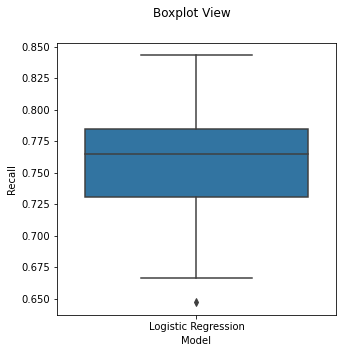

In [10]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [11]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100,
                   solver='liblinear')

Best Parameters: {'clf__C': 10, 'clf__penalty': 'l1'}

 [[65 23]
 [10 30]]

               precision    recall  f1-score   support

   Outcome 0       0.87      0.74      0.80        88
   Outcome 1       0.57      0.75      0.65        40

    accuracy                           0.74       128
   macro avg       0.72      0.74      0.72       128
weighted avg       0.77      0.74      0.75       128

ROC Curve


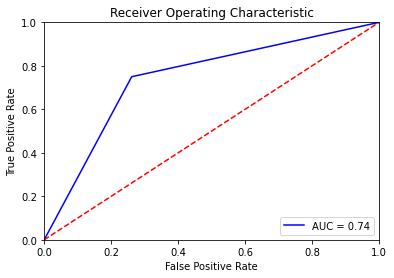

In [12]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [13]:
#Next Steps - Feature Selection using SelectFromModel
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10)
clf.fit(x_train2,y_train)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = dataset.drop('Outcome',axis=1).columns[feature_idx]
print('\nKey Features:',feature_name)


Key Features: Index(['Glucose', 'BMI', 'DiabetesPedigreeFunction'], dtype='object')
